# Import appropriate packages

In [1]:
## Packages for data collection, exploration, and modeling
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

## Web Scraping Packages
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import requests
import time
import random
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chromedriver = "/Users/Carter/Desktop/chromedriver"

## to fill in missing data
from fancyimpute import KNN

## Plotting
import seaborn as sns
%matplotlib inline

/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Notice: You will notice some of the data collection cells have not been run in this notebook.  That is because I completed them in a separate notebook and then copied them here for submission.

# Part 1- Data Collection and introduction to Web Scraping


In [2]:
# initiate webdrive and add extension that blocks ads.  This increases the speed of how fast
# each html page loads
chop = webdriver.ChromeOptions()
chop.add_extension('/Users/Carter/Desktop/Adblock-Plus_v1.13.2.crx')

### Part 1 Step 1: Scrape to get URL's of all basketball players on website
#### Takes ~45 minutes to run on my machine

In [ ]:
browser = webdriver.Chrome(executable_path = chromedriver, chrome_options = chop)

#empty array where we will store player data
player_links = []

page_letters = list("abcdefghijklmnopqrstuvwxyz")

for letter in page_letters:
    
    url = "http://www.basketball-reference.com/players/%s/" % letter
    
    browser.get(url)
    
    html = browser.page_source
    
    # grab inactive players without the strong html tag
    links = Selector(text=html).xpath("//th[@class='left ']/a/@href").extract()
    
    # then grap active players with the strong html tag
    links1 = Selector(text=html).xpath("//th[@class='left ']/strong/a/@href").extract()
    
    #combine the two separate links into one
    links = links + links1
   
    player_links.append(links)
    
    # set up random time interval to mitigate risk of being blocked by the domain
    time.sleep(2*np.random.rand())

browser.quit()

In [ ]:
# create a test links to validate data collection
test_list = player_links[:]

In [ ]:
import itertools
list2d = test_list
merged = list(itertools.chain(*list2d))

# verify list is accurate in terms of length comparted to what the website says.
# will use this link list for data collection on each player
player_links = merged[:]
len(player_links)

### Part 1 Step 2: Iterate through all links to grab each players Stats- NBA general stats, NBA advanced stats, and (if present) College Stats
#### Takes ~3hrs on my machine to run

In [ ]:
browser = webdriver.Chrome(executable_path = chromedriver, chrome_options = chop)

player_stats = []

print datetime.datetime.now().time()

for l in player_links:
    
    player_url = "http://www.basketball-reference.com%s" % l
    
    # get the html of the player page
    browser.get(player_url)
    
    # pull the page source so I can access the data via xpath selector
    player_html = browser.page_source
    
    # grab the name of the player
    name = Selector(text=player_html).xpath("//h1/text()").extract()
    
    # check if 'college' appears on their page
    college = Selector(text=player_html).xpath("//div[@id='all_all_college_stats']/div[@class='section_heading']//h2/text()").extract()
    if not college:
        pass
    else:
    
        player_stats.append({
            "Name": name[0],
            "Lg": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='lg_id']/text()").extract(),
            "G": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='g']/text()").extract(),
            "GS": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='gs']/text()").extract(),
            "MP": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='mp_per_g']/text()").extract(),
            "FG": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg_per_g']/text()").extract(),
            "FGA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fga_per_g']/text()").extract(),
            "FG%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg_pct']/text()").extract(),
            "3P": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3_per_g']/text()").extract(),
            "3PA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3a_per_g']/text()").extract(),
            "3P%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg3_pct']/text()").extract(),
            "2P": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2_per_g']/text()").extract(),
            "2PA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2a_per_g']/text()").extract(),
            "2P%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fg2_pct']/text()").extract(),
            "eFG%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='efg_pct']/text()").extract(),
            "FT": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ft_per_g']/text()").extract(),
            "FTA": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='fta_per_g']/text()").extract(),
            "FT%": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ft_pct']/text()").extract(),
            "ORB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='orb_per_g']/text()").extract(),
            "DRB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='drb_per_g']/text()").extract(),
            "TRB": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='trb_per_g']/text()").extract(),
            "AST": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='ast_per_g']/text()").extract(),
            "STL": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='stl_per_g']/text()").extract(),
            "BLK": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='blk_per_g']/text()").extract(),
            "TOV": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='tov_per_g']/text()").extract(),
            "PF": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='pf_per_g']/text()").extract(),
            "PTS": Selector(text=player_html).xpath("//table[@id='per_game']/tfoot/tr[1]//td[@data-stat='pts_per_g']/text()").extract(),
            "PER": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='per']/text()").extract(),
            "TS%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ts_pct']/text()").extract(),
            "3PAr": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='fg3a_per_fga_pct']/text()").extract(),
            "FTr": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='fta_per_fga_pct']/text()").extract(),
            "ORB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='orb_pct']/text()").extract(),
            "DRB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='drb_pct']/text()").extract(),
            "TRB%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='trb_pct']/text()").extract(),
            "AST%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ast_pct']/text()").extract(),
            "STL%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='stl_pct']/text()").extract(),
            "BLK%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='blk_pct']/text()").extract(),
            "TOV%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='tov_pct']/text()").extract(),
            "USG%": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='usg_pct']/text()").extract(),
            "OWS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ows']/text()").extract(),
            "DWS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='dws']/text()").extract(),
            "WS": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ws']/text()").extract(),
            "WS/48": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='ws_per_48']/text()").extract(),
            "OBPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='obpm']/text()").extract(),
            "DBPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='dbpm']/text()").extract(),
            "BPM": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='bpm']/text()").extract(),
            "VORP": Selector(text=player_html).xpath("//table[@id='advanced']/tfoot/tr[1]//td[@data-stat='vorp']/text()").extract()
            "G": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='g']/text()").extract(),
            "MP": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='mp']/text()").extract(),
            "FG": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg']/text()").extract(),
            "FGA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fga']/text()").extract(),
            "3P": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3']/text()").extract(),
            "3PA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3a']/text()").extract(),
            "FT": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ft']/text()").extract(),
            "FTA": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fta']/text()").extract(),
            "ORB": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='orb']/text()").extract(),
            "TRB": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='trb']/text()").extract(),
            "AST": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ast']/text()").extract(),
            "STL": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='stl']/text()").extract(),
            "BLK": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='blk']/text()").extract(),
            "TOV": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='tov']/text()").extract(),
            "PF": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pf']/text()").extract(),
            "PTS": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pts']/text()").extract(),
            "FG%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg_pct']/text()").extract(),
            "3P%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='fg3_pct']/text()").extract(),
            "FT%": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ft_pct']/text()").extract(),
            "MP_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='mp_per_g']/text()").extract(),
            "PTS_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='pts_per_g']/text()").extract(),
            "TRB_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='trb_per_g']/text()").extract(),
            "AST_per_g": Selector(text=player_html).xpath("//table[@id='all_college_stats']/tfoot/tr[1]//td[@data-stat='ast_per_g']/text()").extract()
            })
    
    # put in random alert ot make sure program is still functioning correctly
    chance = (random.randint(1,100))    
    if chance <= 1:
        print ("1% chance of getting this-- still running")

print datetime.datetime.now().time()
browser.quit()

In [ ]:
# save uncleaned dataframe just in case-- this will make it so I wont have to run scrape program
# again unnecessarily
df = pd.DataFrame(player_stats)
df.shape

df.to_csv(path_or_buf= 'pro_players_v1.csv')

In [ ]:
# start work to clean up player stats
v1 = player_stats[:]

In [ ]:
# function to clean up data
for index, row in enumerate(v1):
    
    for key, value in row.items():
        
        if len(value) < 1:
            v1[index][key] = ""
        elif type(value) == list:
            v1[index][key] = value[0]
        else:
            v1[index][key] = value

In [ ]:
# cleaner dataframe now
df2 = pd.DataFrame(v1)
df2.shape

df2.to_csv(path_or_buf= 'pro_players_v2.csv')

## End of copying the other Jupyter notebook into this one

#### Reading in data that was collected in other jupyter notebook and saved into CSV files

In [2]:
nba = pd.read_csv('old/players_combined.csv')

In [3]:
college = pd.read_csv('old/college_stats.csv')

In [4]:
position = pd.read_csv('old/player_positions.csv')

In [5]:
holder = []
for x in position['Position']:
    if type(x) == float:
        holder.append(str(x))
    else:
        holder.append(x)

position['Position'] = holder

In [6]:
position['Position']= position['Position'].apply(lambda x: x.replace("C-PF", "C").replace("PF-C", "C").replace("PF-SF", "PF").replace("PG-SG", "PG").replace("SF-PF", "SF").replace("SF-SG", "SG").replace("SG-PG", "PG").replace("SG-SF", "SG"))

In [7]:
position.groupby('Position').count()

,Unnamed: 0,Name
Position,,
C,700,700
PF,786,786
PG,713,713
SF,820,820
SG,890,890
nan,551,551


In [8]:
df_position = pd.get_dummies(position['Position'])

In [9]:
df_position.head()

,C,PF,PG,SF,SG,nan
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,1,0


In [10]:
pos_final = pd.concat([position, df_position], axis=1)

In [ ]:
### Should I have dropped 1 dummy variable column?  

#### Add prefix on college stats to differentiate after merge

In [11]:
college.add_prefix('[C]')
college = college.rename(columns={'[C]Name': 'Name'})

### Add position data to existing NBA dataframe

In [12]:
nba = pd.merge(nba, pos_final, on='Name', how='left')

In [13]:
nba.to_csv(path_or_buf= 'carter-working.csv')

### Inner join two files to get less missing data

In [14]:
print nba.shape
print college.shape

(4761, 56)
(2622, 25)


In [15]:
df_inner = pd.merge(nba, college, on='Name', how='inner', suffixes=('_NBA', '_C'))

In [16]:
df_inner.shape

(3168, 80)

In [17]:
df_inner.to_csv(path_or_buf='df_inner.csv')

In [18]:
(len(df_inner)*0.05)

158.4

## Fill missing values of column if less than 40% of values are missing.  Replace with average value BY POSITION of that column.  I need to take this measure to run models 

In [19]:
for col in df_inner.columns:
    nulnum = df_inner[col].isnull().sum() 
#     print col, nulnum
    if 0 < nulnum <= (len(df_inner)*.40):
        df_inner[col].fillna(df_inner.groupby('Position')[col].transform("mean"), inplace=True)
    

### Dropping the rest of the columns that did not make cut in terms of percentage of missing data

In [20]:
data = df_inner.drop(['ORB_C', 'PF', 'TOV_C', 'Name', 'Lg'], axis=1)

In [21]:
data = data.fillna(0)

In [22]:
data.to_csv(path_or_buf='data.csv')

In [23]:
data = data.drop('Unnamed: 0_x', 1)

In [24]:
data = data.drop('Unnamed: 0_y', 1)

#### For some reason adding the suffix's did not work on all columns-- standardizing now for readiability purposes

In [25]:
columns ={
    '2P': '2P_NBA',
    '2P%': '2P%_NBA',
    '2PA': '2PA_NBA',
    'DRB': 'DRB_NBA',
    'GS': 'GS_NBA',
    'PF_x': 'PF_NBA',
    'eFG%': 'eFG%_NBA',
    '3PAr': '3PAr_NBA',
    'AST%': 'AST%_NBA',
    'BLK%': 'BLK%_NBA',
    'BPM': 'BPM_NBA',
    'DBPM': 'DBPM_NBA',
    'DRB%': 'DRB%_NBA',
    'DWS': 'DWS_NBA',
    'FTr': 'FTr_NBA',
    'OBPM': 'OBPM_NBA',
    'ORB%': 'ORB%_NBA',
    'OWS': 'OWS_NBA',
    'PER': 'PER_NBA',
    'STL%': 'STL%_NBA',
    'TOV%': 'TOV%_NBA',
    'TRB%':'TRB%_NBA',
    'TS%': 'TS%_NBA',
    'USG%': 'USG%_NBA',
    'VORP': 'VORP_NBA',
    'WS': 'WS_NBA',
    'WS/48': 'WS/48_NBA',
    'PF_y': 'PF',
    'AST_per_g': 'AST_per_g_C',
    'MP_per_g': 'MP_per_g_C',
    'PTS_per_g':'PTS_per_g_C' ,
    'TRB_per_g': 'TRB_per_g_C'
}

In [45]:
data = data.rename(columns=columns)

In [27]:
data.to_csv(path_or_buf='data_final.csv')

In [28]:
### Just in case - can read in dataset directly from here with completed cleanup

In [6]:
data = pd.read_csv('data_final.csv')

In [7]:
data.shape

(3168, 74)

In [8]:
data = data[data.Position != 'nan']

In [9]:
data.shape

(3168, 74)

### Defining outcome variable

In [10]:
Y1 = data['PER_NBA']

In [11]:
Y1.describe()

count    3168.000000
mean       11.792165
std         6.027877
min       -46.600000
25%         9.400000
50%        12.000000
75%        14.500000
max        88.300000
Name: PER_NBA, dtype: float64

In [27]:
X1 = data[['C','PF','PG','SF','SG','nan','3P_C','3P%_C','3PA_C','AST_C','AST_per_g_C','BLK_C','FG_C','FG%_C','FGA_C','FT_C','FT%_C','FTA_C','G_C', 'MP_C','MP_per_g_C','PTS_C','PTS_per_g_C','STL_C','TRB_C','TRB_per_g_C']]

In [28]:
X1.dtypes

C              float64
PF             float64
PG             float64
SF             float64
SG             float64
nan            float64
3P_C           float64
3P%_C          float64
3PA_C          float64
AST_C          float64
AST_per_g_C    float64
BLK_C          float64
FG_C           float64
FG%_C          float64
FGA_C          float64
FT_C           float64
FT%_C          float64
FTA_C          float64
G_C              int64
MP_C           float64
MP_per_g_C     float64
PTS_C            int64
PTS_per_g_C    float64
STL_C          float64
TRB_C          float64
TRB_per_g_C    float64
dtype: object

In [30]:
print Y1.shape
print X1.shape

(3168,)
(3168, 26)


### Creating own df for data to run models on

In [31]:
df = pd.concat([Y1, X1], axis=1)

In [32]:
df.shape

(3168, 27)

# Part 2: EDA- Initial Exploration of the Data 

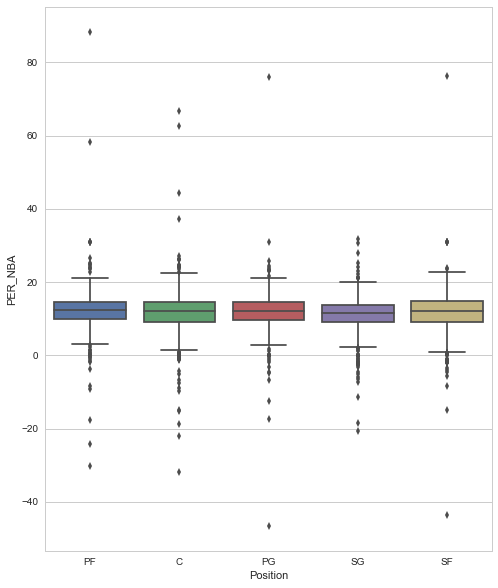

In [24]:
plt.figure(figsize=(8,10))
sns.set_style("whitegrid")

plot1 = sns.boxplot(x="Position", y="PER_NBA", data=data)
boxplot = plot1.get_figure()
boxplot.savefig("boxplot.png")


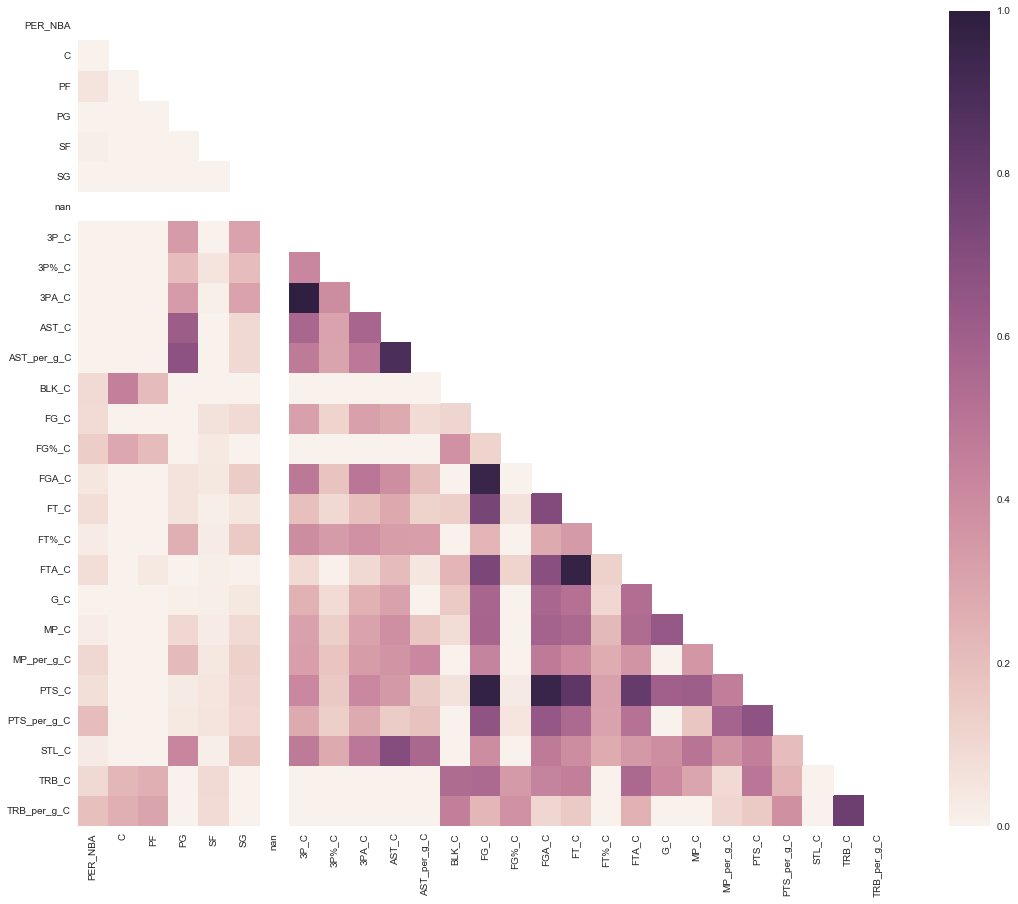

In [49]:
corrmat = df.corr(method='pearson')

fig = plt.figure(figsize=(20,15))

ax= fig.gca()

mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax= sns.heatmap(corrmat, vmin=0, vmax=1, square=True, mask=mask)

heatmap = ax.get_figure()
heatmap.savefig("heatmap.png")


In [13]:
### Inital Regression

In [55]:
model = sm.OLS(Y1, X1, missing='drop')
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                PER_NBA   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     13.21
Date:                Thu, 20 Apr 2017   Prob (F-statistic):           4.22e-50
Time:                        17:03:46   Log-Likelihood:                -10015.
No. Observations:                3163   AIC:                         2.008e+04
Df Residuals:                    3138   BIC:                         2.023e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
C               2.9192      2.561      1.140      

### Start Regularization via Lasso Regression

In [38]:
# Create a function called lasso,
def lasso(alphas):
   
    reg = pd.DataFrame()
    reg['Feature Name'] = X1.columns.tolist()
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)

        lasso.fit(X1, Y1)

        column_name = 'Alpha = %f' % alpha

        reg[column_name] = lasso.coef_

    return reg

In [39]:
lasso([0.001, 0.05, .1])


,Feature Name,Alpha = 0.001000,Alpha = 0.050000,Alpha = 0.100000
0,C,-0.404781,-0.000000,-0.000000
1,PF,0.210008,0.053529,0.000000
2,PG,0.373133,0.000000,0.000000
3,SF,-0.000000,-0.000000,-0.000000
4,SG,-0.358975,-0.233615,-0.000000
5,nan,7.493694,0.000000,0.000000
6,3P_C,0.005063,0.005586,0.004606
7,3P%_C,0.550421,0.000000,-0.000000
8,3PA_C,-0.002385,-0.002596,-0.002413
9,AST_C,-0.002951,0.000814,0.000995


### Does SK Learn yield different results?

In [40]:
lm = linear_model.LinearRegression(normalize=True).fit(X1, Y1)
print metrics.mean_squared_error(Y1, lm.predict(X1)), lm.score(X1, Y1)


32.911285244 0.0939478390729


### What about different types of Regressions?

In [41]:
lm = linear_model.LinearRegression().fit(X1, Y1)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(Y1, lm.predict(X1))
print 'OLS R2:', lm.score(X1, Y1)

lm = linear_model.Lasso().fit(X1, Y1)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(Y1, lm.predict(X1))
print 'Lasso R2:', lm.score(X1, Y1)

lm = linear_model.Ridge().fit(X1, Y1)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(Y1, lm.predict(X1))
print 'Ridge R2:', lm.score(X1, Y1)

~~~ OLS ~~~
OLS MSE:  32.9110651238
OLS R2: 0.0939538990116
~~~ Lasso ~~~
Lasso MSE:  33.5062652746
Lasso R2: 0.0775679578749
~~~ Ridge ~~~
Ridge MSE:  32.9192158718
Ridge R2: 0.0937295078125


### Grid Search 

In [42]:
from sklearn import grid_search

alphas = np.logspace(-1, 1, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(X1, Y1)


/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Carter/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  0.1    ,   0.12589,   0.15849,   0.19953,   0.25119,   0.31623,
         0.39811,   0.50119,   0.63096,   0.79433,   1.     ,   1.25893,
         1.58489,   1.99526,   2.51189,   3.16228,   3.98107,   5.01187,
         6.30957,   7.94328,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [43]:
print -gs.best_score_ 
print gs.best_estimator_ 

33.9430217148
Ridge(alpha=3.1622776601683795, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)


In [44]:
gs.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'estimator__alpha': 1.0,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': None,
 'estimator__normalize': False,
 'estimator__random_state': None,
 'estimator__solver': 'auto',
 'estimator__tol': 0.001,
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'alpha': array([  0.1       ,   0.12589254,   0.15848932,   0.19952623,
           0.25118864,   0.31622777,   0.39810717,   0.50118723,
           0.63095734,   0.79432823,   1.        ,   1.25892541,
           1.58489319,   1.99526231,   2.51188643,   3.16227766,
           3.98107171,   5.01187234,   6.30957344,   7.94328235,  10.        ])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': 'mean_squared_error',
 'verbose': 0}

### What coefficients did Grid Search think were most valuable?

In [45]:
gs.best_estimator_.coef_

array([ -1.27620312e+00,  -6.61690768e-01,  -5.36447317e-01,
        -9.17592193e-01,  -1.28318995e+00,   4.67512335e+00,
         5.30686256e-03,   4.01697633e-01,  -2.38330919e-03,
        -2.43446306e-03,   3.08722425e-01,   7.43828134e-03,
         5.20220001e-03,   5.30311653e+00,  -1.82867347e-03,
         6.66616748e-03,  -3.20372411e-01,  -5.20387903e-03,
        -1.49650163e-02,   4.11932083e-04,  -4.21338250e-02,
        -5.87964231e-04,   1.73668519e-01,   1.11827939e-02,
        -2.69736836e-03,   4.30262728e-01])

In [46]:
pd.DataFrame({'features':X1.columns,'coef':gs.best_estimator_.coef_, 'abs_coef':abs(gs.best_estimator_.coef_)}).sort_values('abs_coef', ascending=False)

,abs_coef,coef,features
13,5.303117,5.303117,FG%_C
5,4.675123,4.675123,nan
4,1.283190,-1.283190,SG
0,1.276203,-1.276203,C
3,0.917592,-0.917592,SF
1,0.661691,-0.661691,PF
2,0.536447,-0.536447,PG
25,0.430263,0.430263,TRB_per_g_C
7,0.401698,0.401698,3P%_C
16,0.320372,-0.320372,FT%_C


In [47]:
from sklearn import preprocessing
from sklearn import utils



### Due to fact that data set has so many variables, attempting PCA so reduce multicollinearity

In [48]:
X1.shape

(3168, 26)

In [49]:
from sklearn import decomposition

print "initial shape: ", X1.shape
pca = decomposition.PCA(n_components=3)
X_r = pca.fit_transform(X1)

print "new feature data after PCA: ", X_r.shape

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

initial shape:  (3168, 26)
new feature data after PCA:  (3168, 3)
explained variance ratio (first two components): [ 0.7319853   0.16661581  0.06267287]


In [50]:
X_r

array([[  773.95248495,    71.89474718,    80.35315136],
       [ -481.09023236,  1228.78018113,   625.36250544],
       [ -109.24244205,   581.50111416,  -538.80383648],
       ..., 
       [  693.22216415,    11.08249183,   188.86010583],
       [  -20.01635243,   170.95624036,   348.201547  ],
       [ 2504.73188409,   -87.54471194,    -7.24505657]])

In [51]:
pca.explained_variance_
# below are eigan values


array([ 1184573.0638036 ,   269634.6524387 ,   101423.61130391])

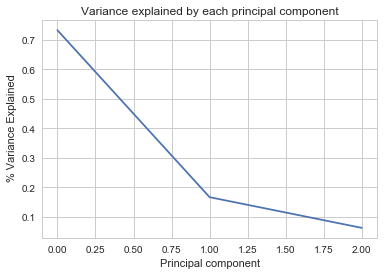

In [52]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Variance explained by each principal component')
plt.ylabel(' % Variance Explained')
plt.xlabel('Principal component')

In [53]:
X_reconstituted = pca.inverse_transform(X_r)


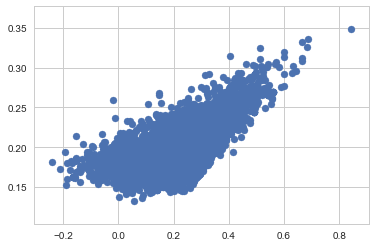

In [54]:
plt.scatter(X_reconstituted[:,1], X_reconstituted[:,3])

### Knn with PCA'd data

In [91]:
knn = KNeighborsClassifier(n_neighbors=10)
cross_val_score(knn, X_r, yknn, cv=3, scoring='accuracy').mean()

0.084150227920707102

##### Curious Comparsion of regression with PCA'd data

In [71]:
lm = linear_model.LinearRegression().fit(X_r, Y1)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(Y1, lm.predict(X_r))
print 'OLS R2:', lm.score(X_r, Y1)

lm = linear_model.Lasso().fit(X_r, Y1)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(Y1, lm.predict(X_r))
print 'Lasso R2:', lm.score(X_r, Y1)

lm = linear_model.Ridge().fit(X_r, Y1)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(Y1, lm.predict(X_r))
print 'Ridge R2:', lm.score(X_r, Y1)

~~~ OLS ~~~
OLS MSE:  35.7626352268
OLS R2: 0.0141243288273
~~~ Lasso ~~~
Lasso MSE:  35.7626496522
Lasso R2: 0.0141239311611
~~~ Ridge ~~~
Ridge MSE:  35.7626352268
Ridge R2: 0.0141243288273


### sklearn Polynomial Features

In [74]:
X1.shape

(3168, 26)

In [75]:
from sklearn.preprocessing import PolynomialFeatures

In [76]:
poly = PolynomialFeatures(3)

In [77]:
poly.fit(X1)

PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)

In [78]:
features = X1.columns.tolist()

In [79]:
polynames = poly.get_feature_names(X1.columns)

In [80]:
X1_poly = poly.fit_transform(X1)

In [81]:
X1_poly.shape

(3168, 3654)

##### ugh, more variables than observations

In [82]:
lm = linear_model.Ridge(normalize=True).fit(X1_poly, Y1)

In [83]:
lm.score(X1_poly, Y1)

0.12909129015219034

In [84]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_poly, Y1, test_size=0.25)

In [85]:
lm_poly = linear_model.Ridge(normalize=True).fit(X1_train, y1_train)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y1_test, lm.predict(X1_test))
print 'Ridge R2:', lm.score(X1_test, y1_test)

~~~ Ridge ~~~
Ridge MSE:  27.2921588842
Ridge R2: 0.11496603885


In [86]:
### Cool, slight improvement

In [87]:
lm.coef_

array([  0.00000000e+00,  -4.28167816e-02,   3.24483886e-02, ...,
        -1.90468818e-09,  -1.59150320e-07,  -4.79910781e-07])

In [88]:
X1.columns.tolist()

['C',
 'PF',
 'PG',
 'SF',
 'SG',
 'nan',
 '3P_C',
 '3P%_C',
 '3PA_C',
 'AST_C',
 'AST_per_g_C',
 'BLK_C',
 'FG_C',
 'FG%_C',
 'FGA_C',
 'FT_C',
 'FT%_C',
 'FTA_C',
 'G_C',
 'MP_C',
 'MP_per_g_C',
 'PTS_C',
 'PTS_per_g_C',
 'STL_C',
 'TRB_C',
 'TRB_per_g_C']

### Coefficienct interpretation for Polynomial model output: one standard deviation of the x leads to one standard deviation change in y 

In [89]:
df_coef = pd.DataFrame({'features':polynames,'coef':lm.coef_, 'abs_coef':abs(lm.coef_)}).sort_values('abs_coef', ascending=False)
df_coef[df_coef['abs_coef']>0]


,abs_coef,coef,features
14,1.473742e+00,1.473742e+00,FG%_C
2423,9.973334e-01,-9.973334e-01,3P%_C FG%_C^2
1164,7.799061e-01,7.799061e-01,PG 3P%_C^2
1440,7.351458e-01,-7.351458e-01,SF 3P%_C^2
287,6.418311e-01,6.418311e-01,FG%_C^2
2426,6.215348e-01,-6.215348e-01,3P%_C FG%_C FT%_C
194,5.821741e-01,-5.821741e-01,3P%_C FG%_C
1693,4.897866e-01,-4.897866e-01,SG 3P%_C^2
8,4.786468e-01,-4.786468e-01,3P%_C
2324,4.763213e-01,-4.763213e-01,3P%_C^3


### Random Forest-- couldn't get this to work all the way

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [71]:
clf = RandomForestRegressor(n_estimators=10000, random_state=0, n_jobs=-1)


In [72]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [73]:
for feature in zip(X1.columns.tolist(), clf.feature_importances_):
    print(feature)

('C', 0.0027274727829686143)
('PF', 0.0044978343563910955)
('PG', 0.0022698704400218039)
('SF', 0.0074663390727143734)
('SG', 0.0041870293464632983)
('nan', 0.00012091372676450003)
('3P_C', 0.03081643418971413)
('3P%_C', 0.036028602186052909)
('3PA_C', 0.036308641224041711)
('AST_C', 0.050658390925524946)
('AST_per_g_C', 0.035626697715152957)
('BLK_C', 0.05450759474872223)
('FG_C', 0.028417977284019326)
('FG%_C', 0.076190363761864791)
('FGA_C', 0.033018123013406717)
('FT_C', 0.035013908584210607)
('FT%_C', 0.050660574622582812)
('FTA_C', 0.037208435418807868)
('G_C', 0.050309685810567883)
('MP_C', 0.039921504046267466)
('MP_per_g_C', 0.064528772691687081)
('PTS_C', 0.026141861646522095)
('PTS_per_g_C', 0.11989771645753348)
('STL_C', 0.06614016155931618)
('TRB_C', 0.036618718710645176)
('TRB_per_g_C', 0.07071637567803564)


In [65]:
clf.score(X_test, y_test)

0.046416599306982054

In [264]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
sfm = SelectFromModel(clf, threshold=0.05)

# Train the selector
sfm.fit(X_train, y_train)


SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False),
        prefit=False, threshold=0.05)

In [265]:
for feature_list_index in sfm.get_support(indices=True):
    print(X1.columns.tolist()[feature_list_index])

AST_C
BLK_C
FG%_C
FT%_C
G_C
MP_per_g_C
PTS_per_g_C
STL_C
TRB_per_g_C


In [266]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [269]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)



In [270]:
# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

ValueError: Unknown label type: 'continuous'

In [268]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature (4 Features) Model
accuracy_score(y_test, y_pred)

ValueError: continuous is not supported